In [45]:
%reset -f
%store -z

In [46]:
from sympy import *
from functools import lru_cache
import re
import numpy as np
import matplotlib.pyplot as plt
lru_cache()
init_printing()

In [47]:
# Rotation Matrix
def R(axis, angle):
    if axis == "x" or axis == "X":
        return Matrix([[1, 0, 0], [0, trigsimp(cos(angle)), trigsimp(-sin(angle))], [0, trigsimp(sin(angle)), trigsimp(cos(angle))]])
    elif axis == "y" or axis == "Y":
        return Matrix([[trigsimp(cos(angle)), 0, trigsimp(sin(angle))], [0, 1, 0], [trigsimp(-sin(angle)), 0, trigsimp(cos(angle))]])
    elif axis == "z" or axis == "Z":
        return Matrix([[trigsimp(cos(angle)), trigsimp(-sin(angle)), 0], [trigsimp(sin(angle)), trigsimp(cos(angle)), 0], [0, 0, 1]])
    else:
        return 0

In [48]:
# Homogenous Transformation
def H(axis,angle,dx,dy,dz):
    r = R(axis,angle)
    return Matrix([[r[0,0], r[0,1], r[0,2], trigsimp(dx)], [r[1,0], r[1,1], r[1,2], trigsimp(dy)], [r[2,0], r[2,1], r[2,2], trigsimp(dz)], [0, 0, 0, 1]])

In [49]:
# Denavit Hartenberg
def DH(a, alpha, d, theta):
    r11 = trigsimp(cos(theta))
    r12 = trigsimp(-sin(theta)*cos(alpha))
    r13 = trigsimp(sin(theta)*sin(alpha))
    r14 = trigsimp(a*cos(theta))
    r21 = trigsimp(sin(theta))
    r22 = trigsimp(cos(theta)*cos(alpha))
    r23 = trigsimp(-cos(theta)*sin(alpha))
    r24 = trigsimp(a*sin(theta))
    r31 = 0
    r32 = trigsimp(sin(alpha))
    r33 = trigsimp(cos(alpha))
    r34 = trigsimp(d)
    r41 = 0
    r42 = 0
    r43 = 0
    r44 = 1
    return Matrix([[r11, r12, r13, r14], [r21, r22, r23, r24], [r31, r32, r33, r34], [r41, r42, r43, r44]])


In [50]:
# Jacobians
def J(i_1, n, type):
    if type == "r" or type == "R":
        return Matrix([[i_1[0,2]], [i_1[1,2]], [i_1[2,2]]]).cross(Matrix([[n[0,3]], [n[1,3]], [n[2,3]]]) - Matrix([[i_1[0,3]], [i_1[1,3]], [i_1[2,3]]])).col_join(Matrix([[i_1[0,2]], [i_1[1,2]], [i_1[2,2]]])).applyfunc(trigsimp)
    elif type == "p" or type == "P":
        return Matrix([[i_1[0,2]], [i_1[1,2]], [i_1[2,2]], [0], [0], [0]])
    else:
        return 0

In [51]:
# dkj(q)
def D(m, i, j, t):
    # m = mass
    # i = inertia
    # j = Jacobians
    # t = Homogenous Transformation --> DH
    jv = j[0:3,0:len(j[1,:])]
    jw = j[3:6,0:len(j[:,1])]
    r = t[0:3,0:3]
    return trigsimp(m * transpose(jv) * jv) + trigsimp(transpose(jw) * r * i * transpose(r) * jw)

In [52]:
# Cijk
def Cijk(d,i,j,k,q):
    return trigsimp((diff(d[k,j],q[i])+diff(d[k,i],q[j])-diff(d[i,j],q[k]))/2)

In [53]:
# C(q)q'
def C(d,q,q_):
    C = zeros(4)
    for k in range(4):
        for j in range(4):
            for i in range(4):
                C[k,j] = trigsimp(C[k,j] + trigsimp(Cijk(d,i,j,k,q)*q_[i]))
    return C

In [54]:
# Potential Energy
def P(m, g, h):
    return trigsimp(trigsimp(m[0]*g*h[0])+trigsimp(m[1]*g*h[1])+trigsimp(m[2]*g*h[2])+trigsimp(m[3]*g*h[3]))

In [55]:
# gk(q)
def G(m, g, h, q):
    p = P(m,g,h)
    return Matrix([[diff(p,q[0])], [diff(p,q[1])], [diff(p,q[2])], [diff(p,q[3])]]).applyfunc(trigsimp)

In [56]:
def matsimp(M):
    m = zeros(shape(M)[0],shape(M)[1])
    for i in range(shape(M)[0]):
        for j in range(shape(M)[1]):
            m[i,j] = trigsimp(M[i,j])
    return m


In [57]:
a1, a2, a3, a4, d1, d2, d3, d4, th1, th2, th3, th4, l1, l2, l3, l4, lc1, lc2, lc3, lc4, m1, m2, m3, m4, I1, I2, I3, I4, g, q_1, q__1, q_2, q__2, q_3, q__3, q_4, q__4 = symbols("a1 a2 a3 a4 d1 d2 d3 d4 theta1 theta2 theta3 theta4 l1 l2 l3 l4 l_c1 l_c2 l_c3 l_c4 m1 m2 m3 m4 I1 I2 I3 I4 g q'_1 q''_1 q'_2 q''_2 q'_3 q''_3 q'_4 q''_4")

In [58]:
# DH-Convention
A1 = DH(a1,90,d1,th1-90)
A2 = DH(a2,0,d2,th2)
A3 = DH(a3,90,d3,th3+90)
A4 = DH(a4,0,d4,th4)


In [59]:
A1 = Matrix([[sin(th1),0,-cos(th1),0],[-cos(th1),0,-sin(th1),0],[0,1,0,d1],[0,0,0,1]])

In [60]:
A3 = Matrix([[-sin(th3),0,cos(th3),0],[cos(th3),0,sin(th3),0],[0,1,0,0],[0,0,0,1]])

In [61]:
T0 = matsimp(eye(4))
T1 = matsimp(A1)
T2 = matsimp(T1*A2)
T3 = matsimp(T2*A3)
T4 = matsimp(T3*A4)

In [62]:
# Jacobians
J_ = matsimp(J(T0,T4,"R").row_join(J(T1,T4,"R")).row_join(J(T2,T4,"R")).row_join(J(T3,T4,"R")))

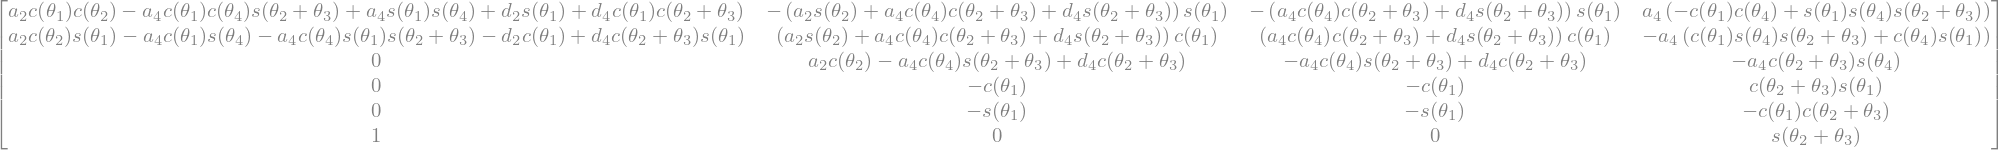

In [63]:
J_.replace(sin,Function("s")).replace(cos,Function("c"))

In [64]:
# Dynamic Model with Euler Lagrange
OC1 = matsimp(H("Z",0,0,0,lc1))
OC2 = matsimp(H("Z",0,lc2*sin(th1)*cos(th2),-lc2*cos(th1)*cos(th2),l1+lc2*sin(th2)))
OC3 = matsimp(H("Z",0,sin(th1)*(l2*cos(th2)+lc3*cos(th2+th3)),-cos(th1)*(l2*cos(th2)+lc3*cos(th2+th3)),l1+l2*sin(th2)+lc3*sin(th2+th3)))
OC4 = matsimp(H("Z",0,sin(th1)*(l2*cos(th2)+cos(th2+th3)*(l3+lc4)),-cos(th1)*(l2*cos(th2)+cos(th2+th3)*(l3+lc4)),l1+l2*sin(th2)+sin(th2+th3)*(l3+lc4)))

In [65]:
J1 = matsimp(J(T0,OC1,"R").row_join(zeros(6,3)))
J2 = matsimp(J(T0,OC2,"R").row_join(J(T1,OC2,"R")).row_join(zeros(6,2)))
J3 = matsimp(J(T0,OC3,"R").row_join(J(T1,OC3,"R")).row_join(J(T2,OC3,"R")).row_join(zeros(6,1)))
J4 = matsimp(J(T0,OC4,"R").row_join(J(T1,OC4,"R")).row_join(J(T2,OC4,"R")).row_join(J(T3,OC4,"R")))

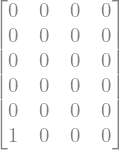

In [66]:
J1.replace(sin,Function("s")).replace(cos,Function("c"))

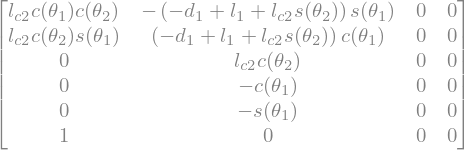

In [67]:
J2.replace(sin,Function("s")).replace(cos,Function("c"))

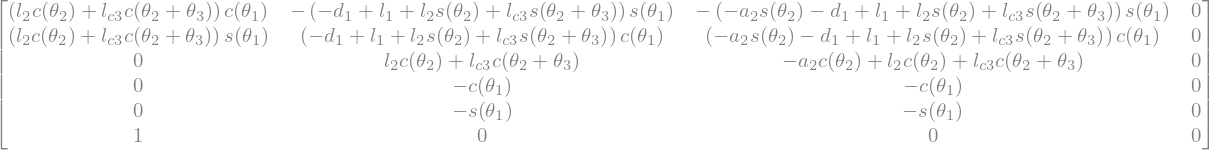

In [68]:
J3.replace(sin,Function("s")).replace(cos,Function("c"))

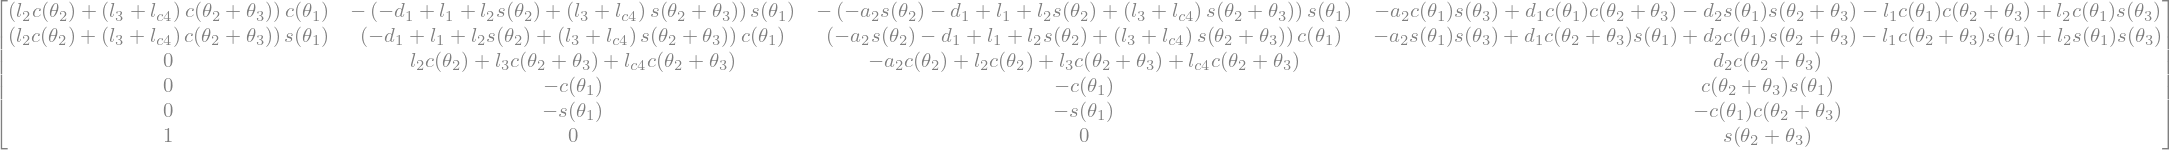

In [69]:
J4.replace(sin,Function("s")).replace(cos,Function("c"))

In [70]:
D_ = matsimp(D(m1,I1,J1,T1)+D(m2,I2,J2,T2)+D(m3,I3,J3,T3)+D(m4,I4,J4,T4))

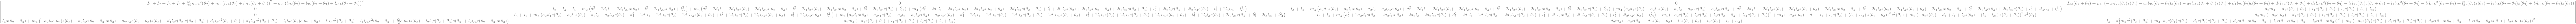

In [71]:
D_.replace(sin,Function("s")).replace(cos,Function("c"))

In [ ]:
C_ = matsimp(C(D_,[th1,th2,th3,th4],[q_1,q_2,q_3,q_4]))

In [ ]:
C_.replace(sin,Function("s")).replace(cos,Function("c"))

In [ ]:
G_ = matsimp(G([m1,m2,m3,m4],g,[OC1[2,3],OC2[2,3],OC3[2,3],OC4[2,3]],[th1,th2,th3,th4]))

In [ ]:
G_.replace(sin,Function("s")).replace(cos,Function("c"))

In [ ]:
DyEq = matsimp((D_*Matrix([[q__1],[q__2],[q__3],[q__4]]))+(C_*Matrix([[q_1],[q_2],[q_3],[q_4]]))+G_)

In [ ]:
DyEq.replace(sin,Function("s")).replace(cos,Function("c"))

In [ ]:
a = [A1,A2,A3,A4]
for i in range(4):
    File = open("src/A"+str(i+1)+".txt","w+",encoding= "utf-8")
    File.write(latex((a[i]).replace(sin,Function("s")).replace(cos,Function("c"))))
    File.close()
    print("A"+str(i+1))

In [ ]:
t = [T0,T1,T2,T3,T4]
for i in range(5):
    File = open("src/T"+str(i)+".txt","w+",encoding= "utf-8")
    File.write(latex((t[i]).replace(sin,Function("s")).replace(cos,Function("c"))))
    File.close()
    print("T"+str(i))

In [ ]:
File = open("src/J_.txt","w+",encoding= "utf-8")
File.write(latex(J_.replace(sin,Function("s")).replace(cos,Function("c"))))
File.close()
print("J_")

In [ ]:
o = [OC1,OC2,OC3,OC4]
for i in range(4):
    File = open("src/OC"+str(i+1)+".txt","w+",encoding= "utf-8")
    File.write(latex(o[i].replace(sin,Function("s")).replace(cos,Function("c"))))
    File.close()
    print("OC"+str(i+1))

In [ ]:
j = [J1,J2,J3,J4]
for i in range(4):
    File = open("src/J"+str(i+1)+".txt","w+",encoding= "utf-8")
    File.write(latex((j[i]).replace(sin,Function("s")).replace(cos,Function("c"))))
    File.close()
    print("J"+str(i+1))

In [ ]:
for i in range(4):
    for j in range(4):
        File = open("src/D_["+str(i)+","+str(j)+"].txt","w+",encoding= "utf-8")
        File.write(latex((D_[i,j]).replace(sin,Function("s")).replace(cos,Function("c"))))
        File.close()
        print("D_["+str(i)+","+str(j)+"]")

In [ ]:
for i in range(4):
    for j in range(4):
        print("C_["+str(i)+","+str(j)+"]")
        File = open("src/C_["+str(i)+","+str(j)+"].txt","w+",encoding= "utf-8")
        File.write(latex((C_[i,j]).replace(sin,Function("s")).replace(cos,Function("c"))))
        File.close()

In [ ]:
File = open("src/P.txt","w+",encoding= "utf-8")
File.write(latex((P([m1,m2,m3,m4],g,[OC1[2,3],OC2[2,3],OC3[2,3],OC4[2,3]])).replace(sin,Function("s")).replace(cos,Function("c"))))
File.close()
print("P")

In [ ]:
for i in range(4):
    for j in range(1):
        File = open("src/G_["+str(i)+","+str(j)+"].txt","w+",encoding= "utf-8")
        File.write(latex((G_[i,j]).replace(sin,Function("s")).replace(cos,Function("c"))))
        File.close()
        print("G_["+str(i)+","+str(j)+"]")

In [ ]:
for i in range(4):
    for j in range(1):
        File = open("src/DyEq["+str(i)+","+str(j)+"].txt","w+",encoding= "utf-8")
        File.write(latex((DyEq[i,j]).replace(sin,Function("s")).replace(cos,Function("c"))))
        File.close()
        print("DyEq["+str(i)+","+str(j)+"]")

In [ ]:
for i in range(4):
    tex = open("src/A"+str(i+1)+".txt","r",encoding= "utf-8")
    Latex = tex.read()
    tex.close()
    Latex = re.sub(r"{\\left\(\\theta",r"\\theta",Latex)
    Latex = re.sub(r"} \\right\)}","}",Latex)
    Latex = re.sub(r"\\theta","",Latex)
    Latex = re.sub(r"} \+ _{","",Latex)
    newtex =  open("src - [SUB]/A"+str(i+1)+".txt","w+",encoding= "utf-8")
    newtex.write(Latex)
    newtex.close()
    print("A"+str(i+1))

In [ ]:
for i in range(5):
    tex = open("src/T"+str(i)+".txt","r",encoding= "utf-8")
    Latex = tex.read()
    tex.close()
    Latex = re.sub(r"{\\left\(\\theta",r"\\theta",Latex)
    Latex = re.sub(r"} \\right\)}","}",Latex)
    Latex = re.sub(r"\\theta","",Latex)
    Latex = re.sub(r"} \+ _{","",Latex)
    newtex =  open("src - [SUB]/T"+str(i)+".txt","w+",encoding= "utf-8")
    newtex.write(Latex)
    newtex.close()
    print("T"+str(i))

In [ ]:
tex = open("src/J_.txt","r",encoding= "utf-8")
Latex = tex.read()
tex.close()
Latex = re.sub(r"{\\left\(\\theta",r"\\theta",Latex)
Latex = re.sub(r"} \\right\)}","}",Latex)
Latex = re.sub(r"\\theta","",Latex)
Latex = re.sub(r"} \+ _{","",Latex)
newtex =  open("src - [SUB]/J_.txt","w+",encoding= "utf-8")
newtex.write(Latex)
newtex.close()
print("J_")

In [ ]:
for i in range(4):
    tex = open("src/OC"+str(i+1)+".txt","r",encoding= "utf-8")
    Latex = tex.read()
    tex.close()
    Latex = re.sub(r"{\\left\(\\theta",r"\\theta",Latex)
    Latex = re.sub(r"} \\right\)}","}",Latex)
    Latex = re.sub(r"\\theta","",Latex)
    Latex = re.sub(r"} \+ _{","",Latex)
    newtex =  open("src - [SUB]/OC"+str(i+1)+".txt","w+",encoding= "utf-8")
    newtex.write(Latex)
    newtex.close()
    print("OC"+str(i+1))

In [ ]:
for i in range(4):
    tex = open("src/J"+str(i+1)+".txt","r",encoding= "utf-8")
    Latex = tex.read()
    tex.close()
    Latex = re.sub(r"{\\left\(\\theta",r"\\theta",Latex)
    Latex = re.sub(r"} \\right\)}","}",Latex)
    Latex = re.sub(r"\\theta","",Latex)
    Latex = re.sub(r"} \+ _{","",Latex)
    newtex =  open("src - [SUB]/J"+str(i+1)+".txt","w+",encoding= "utf-8")
    newtex.write(Latex)
    newtex.close()
    print("J"+str(i+1))

In [ ]:
for i in range(4):
    for j in range(4):
        tex = open("src/D_["+str(i)+","+str(j)+"].txt","r",encoding= "utf-8")
        Latex = tex.read()
        tex.close()
        Latex = re.sub(r"{\\left\(\\theta",r"\\theta",Latex)
        Latex = re.sub(r"} \\right\)}","}",Latex)
        Latex = re.sub(r"\\theta","",Latex)
        Latex = re.sub(r"} \+ _{","",Latex)
        newtex =  open("src - [SUB]/D_["+str(i)+","+str(j)+"].txt","w+",encoding= "utf-8")
        newtex.write(Latex)
        newtex.close()
        print("D_["+str(i)+","+str(j)+"]")

In [ ]:
for i in range(4):
    for j in range(4):
        tex = open("src/C_["+str(i)+","+str(j)+"].txt","r",encoding= "utf-8")
        Latex = tex.read()
        tex.close()
        Latex = re.sub(r"{\\left\(\\theta",r"\\theta",Latex)
        Latex = re.sub(r"} \\right\)}","}",Latex)
        Latex = re.sub(r"\\theta","",Latex)
        Latex = re.sub(r"} \+ _{","",Latex)
        newtex =  open("src - [SUB]/C_["+str(i)+","+str(j)+"].txt","w+",encoding= "utf-8")
        newtex.write(Latex)
        newtex.close()
        print("C_["+str(i)+","+str(j)+"]")

In [ ]:
tex = open("src/P.txt","r",encoding= "utf-8")
Latex = tex.read()
tex.close()
Latex = re.sub(r"{\\left\(\\theta",r"\\theta",Latex)
Latex = re.sub(r"} \\right\)}","}",Latex)
Latex = re.sub(r"\\theta","",Latex)
Latex = re.sub(r"} \+ _{","",Latex)
newtex =  open("src - [SUB]/P.txt","w+",encoding= "utf-8")
newtex.write(Latex)
newtex.close()
print("P")

In [ ]:
for i in range(4):
    for j in range(1):
        tex = open("src/G_["+str(i)+","+str(j)+"].txt","r",encoding= "utf-8")
        Latex = tex.read()
        tex.close()
        Latex = re.sub(r"{\\left\(\\theta",r"\\theta",Latex)
        Latex = re.sub(r"} \\right\)}","}",Latex)
        Latex = re.sub(r"\\theta","",Latex)
        Latex = re.sub(r"} \+ _{","",Latex)
        newtex =  open("src - [SUB]/G_["+str(i)+","+str(j)+"].txt","w+",encoding= "utf-8")
        newtex.write(Latex)
        newtex.close()
        print("G_["+str(i)+","+str(j)+"]")

In [ ]:
for i in range(4):
    for j in range(1):
        tex = open("src/DyEq["+str(i)+","+str(j)+"].txt","r",encoding= "utf-8")
        Latex = tex.read()
        tex.close()
        Latex = re.sub(r"{\\left\(\\theta",r"\\theta",Latex)
        Latex = re.sub(r"} \\right\)}","}",Latex)
        Latex = re.sub(r"\\theta","",Latex)
        Latex = re.sub(r"} \+ _{","",Latex)
        newtex =  open("src - [SUB]/DyEq["+str(i)+","+str(j)+"].txt","w+",encoding= "utf-8")
        newtex.write(Latex)
        newtex.close()
        print("DyEq["+str(i)+","+str(j)+"]")

In [ ]:
a1 = 0
a2 = 219.18
a3 = 0
a4 = 0
d1 = 302.69
d2 = 0
d3 = 0
d4 = 77.3
A1 = DH(a1,90,d1,th1-90)
A2 = DH(a2,0,d2,th2)
A3 = DH(a3,90,d3,th3+90)
A4 = DH(a4,0,d4,th4)
A1 = Matrix([[sin(th1),0,-cos(th1),0],[-cos(th1),0,-sin(th1),0],[0,1,0,d1],[0,0,0,1]])
A3 = Matrix([[-sin(th3),0,cos(th3),0],[cos(th3),0,sin(th3),0],[0,1,0,0],[0,0,0,1]])
T0 = matsimp(eye(4))
T1 = matsimp(A1)
T2 = matsimp(T1*A2)
T3 = matsimp(T2*A3)
T4 = matsimp(T3*A4)

In [ ]:
x = T4[0,3]
y = T4[1,3]
z = T4[2,3]
x = lambdify([th1,th2,th3,th4],x,"numpy")
y = lambdify([th1,th2,th3,th4],y,"numpy")
z = lambdify([th1,th2,th3,th4],z,"numpy")

In [ ]:
N = 1000
#th1_min = -150*(22/7)/180
#th1_max = 150*(22/7)/180
th1_min = 0*(22/7)/180
th1_max = 360*(22/7)/180
th2_min = -45*(22/7)/180
th2_max = 225*(22/7)/180
th3_min = -135*(22/7)/180
th3_max = 135*(22/7)/180
th1_start_end = [th1_min,th1_max]
th2_start_end = [th2_min,th2_max]
th3_start_end = [th3_min,th3_max]
th1 = np.linspace(th1_min,th1_max,N)
th2 = np.linspace(th2_min,th2_max,N)
th3 = np.linspace(th3_min,th3_max,N)
X = []
Y = []
Z = []
for i in th1:
    X.append(x(i,0,0,0))
    Y.append(y(i,0,0,0))
    Z.append(z(i,0,0,0))
#for i in th2:
#    if(i <= 90*(22/7)/180):
#        X.append(x(th1_max,i,0,0))
#        Y.append(y(th1_max,i,0,0))
#        Z.append(z(th1_max,i,0,0))
#for i in th2:
#    if(i <= 90*(22/7)/180):
#        X.append(x(th1_min,i,0,0))
#        Y.append(y(th1_min,i,0,0))
#        Z.append(z(th1_min,i,0,0))
plt.scatter(X,Y)

In [ ]:
N = 1000
#th1_min = -150*(22/7)/180
#th1_max = 150*(22/7)/180
th1_min = 0*(22/7)/180
th1_max = 360*(22/7)/180
th2_min = -45*(22/7)/180
th2_max = 225*(22/7)/180
th3_min = -135*(22/7)/180
th3_max = 135*(22/7)/180
th1_start_end = [th1_min,th1_max]
th2_start_end = [th2_min,th2_max]
th3_start_end = [th3_min,th3_max]
th1 = np.linspace(th1_min,th1_max,N)
th2 = np.linspace(th2_min,th2_max,N)
th3 = np.linspace(th3_min,th3_max,N)
X = []
Y = []
Z = []
for i in th1:
    X.append(x(i,0,0,0))
    Y.append(y(i,0,0,0))
    Z.append(z(i,0,0,0))
for i in th1:
    X.append(x(i,th2_min,th3_min,0))
    Y.append(y(i,th2_min,th3_min,0))
    Z.append(z(i,th2_min,th3_min,0))
#for i in th2:
#    if(i <= 0):
#        X.append(x(th1_max,i,0,0))
#        Y.append(y(th1_max,i,0,0))
#        Z.append(z(th1_max,i,0,0))
#for i in th2:
#    if(i <= 0):
#        X.append(x(th1_min,i,0,0))
#        Y.append(y(th1_min,i,0,0))
#        Z.append(z(th1_min,i,0,0))
#for i in th3:
#    if(i <= 0):
#        X.append(x(th1_min,th2_min,i,0))
#        Y.append(y(th1_min,th2_min,i,0))
#        Z.append(z(th1_min,th2_min,i,0))
#for i in th3:
#    if(i <= 0):
#        X.append(x(th1_max,th2_min,i,0))
#        Y.append(y(th1_max,th2_min,i,0))
#        Z.append(z(th1_max,th2_min,i,0))
plt.scatter(X,Y)

In [ ]:
N = 1000
th1_min = -90*(22/7)/180
th1_max = 90*(22/7)/180
th2_min = -45*(22/7)/180
th2_max = 225*(22/7)/180
th3_min = -135*(22/7)/180
th3_max = 135*(22/7)/180
th1_start_end = [th1_min,th1_max]
th2_start_end = [th2_min,th2_max]
th3_start_end = [th3_min,th3_max]
th1 = np.linspace(th1_min,th1_max,N)
th2 = np.linspace(th2_min,th2_max,N)
th3 = np.linspace(th3_min,th3_max,N)
X = []
Y = []
Z = []
for i in th2:
    X.append(x(th1_max,i,0,0))
    Y.append(y(th1_max,i,0,0))
    Z.append(z(th1_max,i,0,0))
for i in th3:
    if(i <= 0):
        X.append(x(th1_min,th2_min,i,0))
        Y.append(y(th1_min,th2_min,i,0))
        Z.append(z(th1_min,th2_min,i,0))
for i in th3:
    if(i >= 0):
        X.append(x(th1_min,th2_max,i,0))
        Y.append(y(th1_min,th2_max,i,0))
        Z.append(z(th1_min,th2_max,i,0))
for i in th2:
    X.append(x(th1_max,i,th3_min,0))
    Y.append(y(th1_max,i,th3_min,0))
    Z.append(z(th1_max,i,th3_min,0))
for i in th2:
    X.append(x(th1_max,i,th3_max,0))
    Y.append(y(th1_max,i,th3_max,0))
    Z.append(z(th1_max,i,th3_max,0))
plt.scatter(X,Z)

In [ ]:
N = 1000
th1_min = -150*(22/7)/180
th1_max = 150*(22/7)/180
th2_min = -45*(22/7)/180
th2_max = 225*(22/7)/180
th3_min = -135*(22/7)/180
th3_max = 135*(22/7)/180
th1_start_end = [th1_min,th1_max]
th2_start_end = [th2_min,th2_max]
th3_start_end = [th3_min,th3_max]
th1 = np.linspace(th1_min,th1_max,N)
th2 = np.linspace(th2_min,th2_max,N)
th3 = np.linspace(th3_min,th3_max,N)
X = []
Y = []
Z = []
for i in th2:
    X.append(x(th1_max,i,0,0))
    Y.append(y(th1_max,i,0,0))
    Z.append(z(th1_max,i,0,0))
for i in th3:
    if(i <= 0):
        X.append(x(th1_max,th2_min,i,0))
        Y.append(y(th1_max,th2_min,i,0))
        Z.append(z(th1_max,th2_min,i,0))
for i in th3:
    if(i >= 0):
        X.append(x(th1_max,th2_max,i,0))
        Y.append(y(th1_max,th2_max,i,0))
        Z.append(z(th1_max,th2_max,i,0))
for i in th2:
    X.append(x(th1_max,i,th3_min,0))
    Y.append(y(th1_max,i,th3_min,0))
    Z.append(z(th1_max,i,th3_min,0))
for i in th2:
    X.append(x(th1_max,i,th3_max,0))
    Y.append(y(th1_max,i,th3_max,0))
    Z.append(z(th1_max,i,th3_max,0))
plt.scatter(Y,Z)

In [ ]:
N = 1000
th1_min = 0*(22/7)/180
th1_max = 360*(22/7)/180
th2_min = -45*(22/7)/180
th2_max = 225*(22/7)/180
th3_min = -135*(22/7)/180
th3_max = 135*(22/7)/180
th4_min = -155*(22/7)/180
th4_max = 155*(22/7)/180
th1_start_end = [th1_min,th1_max]
th2_start_end = [th2_min,th2_max]
th3_start_end = [th3_min,th3_max]
th1 = np.linspace(th1_min,th1_max,N)
th2 = np.linspace(th2_min,th2_max,N)
th3 = np.linspace(th3_min,th3_max,N)
XYX1 = []
XYY1 = []
for i in th1:
    XYX1.append(x(i,0,0,0))
    XYY1.append(y(i,0,0,0))

XYX2 = []
XYY2 = []
for i in th1:
    XYX2.append(x(i,0,0,0))
    XYY2.append(y(i,0,0,0))
    XYX2.append(x(i,th2_min,th3_min,0))
    XYY2.append(y(i,th2_min,th3_min,0))

YZY = []
YZZ = []
for i in th2:
    YZY.append(y(th1_max,i,0,0))
    YZZ.append(z(th1_max,i,0,0))
    YZY.append(y(th1_max,i,th3_min,0))
    YZZ.append(z(th1_max,i,th3_min,0))
    YZY.append(y(th1_max,i,th3_max,0))
    YZZ.append(z(th1_max,i,th3_max,0))
for i in th3:
    if(i <= 0):
        YZY.append(y(th1_max,th2_min,i,0))
        YZZ.append(z(th1_max,th2_min,i,0))
    if(i >= 0):
        YZY.append(y(th1_max,th2_max,i,0))
        YZZ.append(z(th1_max,th2_max,i,0))

th1_min = -90*(22/7)/180
th1_max = 90*(22/7)/180
XZX = []
XZZ = []
for i in th2:
    XZX.append(x(th1_max,i,0,0))
    XZZ.append(z(th1_max,i,0,0))
for i in th3:
    if(i <= 0):
        XZX.append(x(th1_min,th2_min,i,0))
        XZZ.append(z(th1_min,th2_min,i,0))
    if(i >= 0):
        XZX.append(x(th1_min,th2_max,i,0))
        XZZ.append(z(th1_min,th2_max,i,0))
for i in th2:
    XZX.append(x(th1_max,i,th3_min,0))
    XZZ.append(z(th1_max,i,th3_min,0))
    XZX.append(x(th1_max,i,th3_max,0))
    XZZ.append(z(th1_max,i,th3_max,0))


fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0,0].set_title("XY (Top)")
axs[0,0].scatter(XYX1,XYY1)
plt.setp(axs[0,0],xlabel="x (mm)")
plt.setp(axs[0,0],ylabel="y (mm)")
axs[0,1].set_title("XY (Bottom)")
axs[0,1].scatter(XYX2,XYY2)
plt.setp(axs[0,1],xlabel="x (mm)")
plt.setp(axs[0,1],ylabel="y (mm)")
axs[1,0].set_title("XZ")
axs[1,0].scatter(XZX,XZZ)
plt.setp(axs[1,0],xlabel="x (mm)")
plt.setp(axs[1,0],ylabel="z (mm)")
axs[1,1].set_title("YZ")
axs[1,1].scatter(YZY,YZZ)
plt.setp(axs[1,1],xlabel="y (mm)")
plt.setp(axs[1,1],ylabel="z (mm)")
fig.tight_layout()
plt.show()

In [102]:
nx, ny,nz, ox, oy, oz, ax, ay, az, px, py, pz = symbols("n_x n_y n_z o_x o_y o_z a_x a_y a_z p_x p_y p_z")

In [116]:
Tdesired = Matrix([[nx,ox,ax,px],[ny,oy,ay,py],[nz,oz,az,pz],[0,0,0,1]])

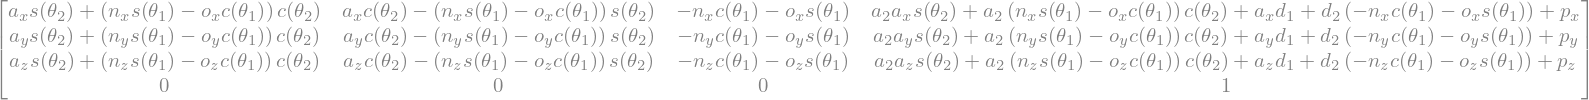

In [120]:
(Tdesired*A1*A2).replace(sin,Function("s")).replace(cos,Function("c"))

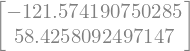

In [175]:
#th1
x = -18.24
y = 11.21
theta1 = Matrix([[(atan2(x*pi/180,-y*pi/180)*180/pi).evalf()],[(atan2(x*pi/180,-y*pi/180)*(180/pi)+180).evalf()]])
theta1

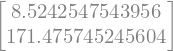

In [19]:
#th3
x = 11.01
y = -41.07
z = 50.81
d1 = 10
a2 = 15
a3 = 20
a4 = 25
D = (pow(x,2)+pow(y,2)+pow(z-d1,2)-pow(a2,2)-pow(a3,2)-pow(a4,2))/(2*a2*a3*a4)
theta3 = Matrix([[(atan2(D*pi/180,sqrt(1-pow(D,2))*pi/180)*180/pi).evalf()],[(atan2(D*pi/180,-sqrt(1-pow(D,2))*pi/180)*180/pi).evalf()]])
theta3

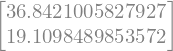

In [20]:
#th2
theta2 = Matrix([[(atan2(sqrt(pow(x,2)+pow(y,2))*pi/180,(z-d1)*pi/180)*(180/pi)-atan2((a2+a3*cos(theta3[0,0]))*pi/180,a3*sin(theta3[0,0])*pi/180)*(180/pi)).evalf()],[(atan2(sqrt(pow(x,2)+pow(y,2))*pi/180,(z-d1)*pi/180)*(180/pi)-atan2((a2+a3*cos(theta3[1,0]))*pi/180,a3*sin(theta3[1,0])*pi/180)*(180/pi)).evalf()]])
theta2